# 1. Loading

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from loguru import logger
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

random_seed = 42

In [31]:
WINDOW_LENGTH = "5min"

In [32]:
notebook_dir = os.getcwd()
notebook_parent_dir = os.path.dirname(notebook_dir)
notebook_parent_parent_dir = os.path.dirname(notebook_parent_dir)
engineered_data_path = os.path.join(notebook_parent_parent_dir, 'data', 'engineered', f'engineered_features_{WINDOW_LENGTH}.csv')

In [33]:
df = pd.read_csv(engineered_data_path)
df["window_start"] = pd.to_datetime(df["window_start"], format='ISO8601', utc=True)

In [34]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 47597 entries, 0 to 47596
Data columns (total 55 columns):
 #   Column                                                                 Non-Null Count  Dtype              
---  ------                                                                 --------------  -----              
 0   seg_id                                                                 47597 non-null  int64              
 1   window_start                                                           47597 non-null  datetime64[us, UTC]
 2   Vessel Hull Over Ground Speed (knots)                                  47597 non-null  float64            
 3   Vessel Hull Through Water Longitudinal Speed (knots)                   47597 non-null  float64            
 4   Vessel External Conditions Wind Relative Speed (knots)                 47597 non-null  float64            
 5   Vessel External Conditions Wind Relative Angle (degrees)               47597 non-null  float64            
 6   V

# 2. Modelling-specific preprocessing

# 3. Shaft power prediction benchmark

This section defines a predictor set and benchmarks multiple machine learning models to predict shaft power.

## 3.1. Back of the envelope version

In [52]:
TARGET_COLUMN = "Vessel Propeller Shaft Mechanical Power (KW)"

predictive_sensor_variables = [
    "Avg Draft (Calculated)",
    "Vessel Hull Through Water Longitudinal Speed (knots)",
    "Days Since Last Cleaning"
#    "Main Engine Fuel Load % (%)",
#    "Vessel Propeller Shaft Thrust Force (KN)",
#    "Vessel Propeller Shaft Rotational Speed (rpm)",
]

predictive_weather_variables = [
    "Vessel External Conditions Wind Relative Angle (degrees)",
    "Vessel External Conditions Wind Relative Speed (knots)",
    "Vessel External Conditions Sea Water Temperature (Provider S)",
    "Vessel External Conditions Northward Sea Water Velocity (Provider MB)",
    "Vessel External Conditions Eastward Sea Water Velocity (Provider MB)",
    "Vessel External Conditions Wave Significant Height (Provider MB)",
    "Vessel External Conditions Swell Significant Height (Provider MB)",
    "Vessel External Conditions Eastward Wind Velocity (Provider S)",
    "Vessel External Conditions Wind True Angle (Provider MB)",
    "Vessel External Conditions Wind True Speed (Provider MB)",
]

all_predictive_variables = predictive_sensor_variables + predictive_weather_variables

print(f"Target variable: {TARGET_COLUMN}")
print(f"Number of predictive variables: {len(all_predictive_variables)}")
print("Predictive variables:")
for variable in all_predictive_variables:
    print(f"- {variable}")

Target variable: Vessel Propeller Shaft Mechanical Power (KW)
Number of predictive variables: 13
Predictive variables:
- Avg Draft (Calculated)
- Vessel Hull Through Water Longitudinal Speed (knots)
- Days Since Last Cleaning
- Vessel External Conditions Wind Relative Angle (degrees)
- Vessel External Conditions Wind Relative Speed (knots)
- Vessel External Conditions Sea Water Temperature (Provider S)
- Vessel External Conditions Northward Sea Water Velocity (Provider MB)
- Vessel External Conditions Eastward Sea Water Velocity (Provider MB)
- Vessel External Conditions Wave Significant Height (Provider MB)
- Vessel External Conditions Swell Significant Height (Provider MB)
- Vessel External Conditions Eastward Wind Velocity (Provider S)
- Vessel External Conditions Wind True Angle (Provider MB)
- Vessel External Conditions Wind True Speed (Provider MB)


In [53]:
model_df = (
    df[["window_start", TARGET_COLUMN] + all_predictive_variables]
    .sort_values("window_start")
    .dropna()
    .copy()
)

X = model_df[all_predictive_variables]
y = model_df[TARGET_COLUMN]

print(f"Rows available for modelling: {len(model_df):,}")
print(f"Feature matrix shape: {X.shape}")

Rows available for modelling: 44,860
Feature matrix shape: (44860, 13)


In [54]:
split_index = int(len(model_df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

numeric_preprocessor = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_preprocessor, all_predictive_variables),
    ]
)

models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=random_seed,
        n_jobs=-1,
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=random_seed),
}

print(f"Train rows: {len(X_train):,}")
print(f"Test rows:  {len(X_test):,}")

Train rows: 35,888
Test rows:  8,972


In [55]:
tscv = TimeSeriesSplit(n_splits=5)

scoring = {
    "mape": "neg_mean_absolute_percentage_error",
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

results = []

for model_name, estimator in models.items():
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", estimator),
        ]
    )

    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=tscv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )

    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict(X_test)

    results.append(
        {
            "model": model_name,
            "cv_rmse_mean": -cv_scores["test_rmse"].mean(),
            "cv_mape_mean": -cv_scores["test_mape"].mean(),
            "cv_mae_mean": -cv_scores["test_mae"].mean(),
            "cv_r2_mean": cv_scores["test_r2"].mean(),
            "test_rmse": mean_squared_error(y_test, y_pred_test),
            "test_mape": mean_absolute_percentage_error(y_test, y_pred_test),
            "test_mae": mean_absolute_error(y_test, y_pred_test),
            "test_r2": r2_score(y_test, y_pred_test),
        }
    )

results_df = pd.DataFrame(results).sort_values("test_rmse", ascending=True)
results_df.reset_index(drop=True, inplace=True)
results_df

,model,cv_rmse_mean,cv_mape_mean,cv_mae_mean,cv_r2_mean,test_rmse,test_mape,test_mae,test_r2
0,Ridge,1108.094497,0.247022,906.996536,-0.927971,4.288981e+05,0.209699,531.362020,-2.038481
1,GradientBoosting,1098.628317,0.251765,873.562877,-0.889023,1.857997e+06,0.501616,1234.764035,-12.162776
2,RandomForest,1123.248539,0.241260,886.988232,-1.014207,2.538095e+06,0.494173,1214.989039,-16.980853


Text(0, 0.5, 'Frequency')

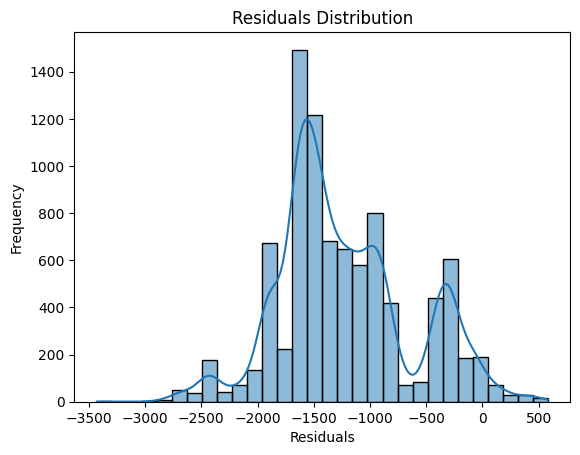

In [57]:
rmse = root_mean_squared_error(y_test, y_pred_test)  # true RMSE [web:156]
# or:
rmse = mean_squared_error(y_test, y_pred_test)  # squared=False => RMSE [web:155]

histogram = sns.histplot(y_test - y_pred_test, bins=30, kde=True)
histogram.set_title("Residuals Distribution")
histogram.set_xlabel("Residuals")
histogram.set_ylabel("Frequency")

#### needed additions for Laurie et al reproduction

In [ ]:
# 1. Fit a model on the training data
# 2. Use that model to make predictions on a synthetic test set (e.g. averages)
# 3. Evaluate if it is congruent with expectations (e.g. implied added resistance over time days since clean, etc.)